In [9]:
import numpy as np
from numpy import sqrt, log, pi

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pylab import rc
from matplotlib.colors import LogNorm
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import sys
sys.path.append("../")
from signal_generators import *



##################### UNIVERSAL CONSTANTS #####################
S_PER_DAY = 3600*24
DUNE_MASS = 50000  # kg
DUNE_ATOMIC_MASS = 37.211e3  # mass of target atom in MeV
LAR_Z = 18  # atomic number
EXPOSURE_YEARS = 3.5
EXPOSURE_DAYS = EXPOSURE_YEARS*365  # days of exposure
DUNE_AREA = 7.0*5.0  # cross-sectional det area
DUNE_THRESH = 1.0  # energy threshold [MeV]
DUNE_LENGTH=3.0
DUNE_DIST=574
DUNE_SOLID_ANGLE = np.arctan(sqrt(DUNE_AREA / pi) / DUNE_DIST)
DUNE_POT_PER_YEAR = 1.1e21

FLUX_SCALING = EXPOSURE_DAYS*S_PER_DAY * (DUNE_POT_PER_YEAR / 365.0 / S_PER_DAY)  # gets (exposure in s) * (# / s)

E2GAMMA_MISID = 0.18



# Get neutrino rates per 3.5 years
numu_fhc_diff_flux = np.genfromtxt("data/numu_flux_DUNE_FHC_per1GeV_m2_POT.txt")
numu_fhc_diff_flux[:,1] *= 0.25 * EXPOSURE_YEARS*DUNE_POT_PER_YEAR*DUNE_AREA  # multiply by 250 MeV avg bin size

nue_fhc_diff_flux = np.genfromtxt("data/nue_flux_DUNE_FHC_per_1GeV_m2_POT.txt")
nue_fhc_diff_flux[:,1] *= 0.25 * EXPOSURE_YEARS*DUNE_POT_PER_YEAR*DUNE_AREA  # multiply by 250 MeV avg bin size

numubar_fhc_diff_flux = np.genfromtxt("data/numubar_flux_DUNE_FHC_per1GeV_m2_POT.txt")
numubar_fhc_diff_flux[:,1] *= 0.25 * EXPOSURE_YEARS*DUNE_POT_PER_YEAR*DUNE_AREA  # multiply by 250 MeV avg bin size

nuebar_fhc_diff_flux = np.genfromtxt("data/nuebar_flux_DUNE_FHC_per1GeV_m2_POT.txt")
nuebar_fhc_diff_flux[:,1] *= 0.25 * EXPOSURE_YEARS*DUNE_POT_PER_YEAR*DUNE_AREA  # multiply by 250 MeV avg bin size

# after multiplying by factors, we have N_nu(E_nu) per 3.5 years


nu_e_bin_edges= np.arange(875, 30250, 250)
nu_e_bin_centers = (nu_e_bin_edges[1:] + nu_e_bin_edges[:-1])/2
numu_fhc_diff_flux[:,0] = nu_e_bin_centers
nue_fhc_diff_flux[:,0] = nu_e_bin_centers
numubar_fhc_diff_flux[:,0] = nu_e_bin_centers
nuebar_fhc_diff_flux[:,0] = nu_e_bin_centers


numu_xs_dat = np.genfromtxt("data/numu_xs_dividedByEnergy_in_cm-2.txt")
numubar_xs_dat = np.genfromtxt("data/numubar_xs_dividedByEnergy_in_cm-2.txt")

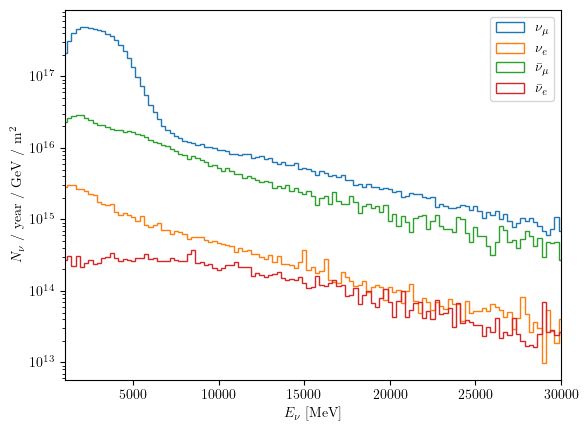

In [10]:

# reproduce

reweight = 1/(EXPOSURE_YEARS*DUNE_AREA*0.25)

plt.hist(numu_fhc_diff_flux[:,0], weights=numu_fhc_diff_flux[:,1]*reweight, bins=nu_e_bin_edges, label=r"$\nu_\mu$", histtype='step')
plt.hist(nue_fhc_diff_flux[:,0],  weights=nue_fhc_diff_flux[:,1]*reweight, bins=nu_e_bin_edges,  label=r"$\nu_e$", histtype='step')
plt.hist(numubar_fhc_diff_flux[:,0],  weights=numubar_fhc_diff_flux[:,1]*reweight, bins=nu_e_bin_edges,  label=r"$\bar{\nu}_\mu$", histtype='step')
plt.hist(nuebar_fhc_diff_flux[:,0],  weights=nuebar_fhc_diff_flux[:,1]*reweight, bins=nu_e_bin_edges,  label=r"$\bar{\nu}_e$", histtype='step')
plt.yscale('log')
#plt.xscale('log')
plt.xlim((1000, 30e3))
plt.xlabel(r"$E_\nu$ [MeV]")
plt.ylabel(r"$N_\nu$ / year / GeV / m$^2$")
plt.legend()
plt.show()

In [11]:
# Declare detector and target materials
dune_nd = Material("Ar")
dune_target = Material("C")

ntargets_per_cm3 = (dune_nd.density * AVOGADRO / (dune_nd.n[0] + dune_nd.z[0]))
n_interactions_genie = 1e7



NU_MU_REWGT = (0.96e8/1e7)
NU_MUBAR_REWGT = (0.028e8/1e7)
NU_E_REWGT = (0.007e8/1e7)
NU_EBAR_REWGT = (0.001e8/1e7)

def numu_events(enu):
    return NU_MU_REWGT * np.ones_like(enu)

def nue_events(enu):
    return NU_E_REWGT * np.ones_like(enu)

def numubar_events(enu):
    return NU_MUBAR_REWGT * np.ones_like(enu)

def nuebar_events(enu):
    return NU_EBAR_REWGT * np.ones_like(enu)


######### DEPRECATED ###############

# take in enu in MeV
# cross sections from 1305.7513
def numu_xs(enu):
    return (enu/1000.0) * 10**np.interp(log10(enu/1000.0), log10(numu_xs_dat[:,0]), log10(numu_xs_dat[:,1]))

def numubar_xs(enu):
    return (enu/1000.0) * 10**np.interp(log10(enu/1000.0), log10(numubar_xs_dat[:,0]), log10(numubar_xs_dat[:,1]))


# flux interpolations
def numu_diff_flux(enu):
    return 10**np.interp(enu, numu_fhc_diff_flux[:,0], np.log10(numu_fhc_diff_flux[:,1]))

def nue_diff_flux(enu):
    return 10**np.interp(enu, nue_fhc_diff_flux[:,0], np.log10(nue_fhc_diff_flux[:,1]))

def numubar_diff_flux(enu):
    return 10**np.interp(enu, numubar_fhc_diff_flux[:,0], np.log10(numubar_fhc_diff_flux[:,1]))

def nuebar_diff_flux(enu):
    return 10**np.interp(enu, nuebar_fhc_diff_flux[:,0], np.log10(nuebar_fhc_diff_flux[:,1]))


# convolve fluxes times xs:
#def numu_events(enu):
#    return numu_diff_flux(enu) * numu_xs(enu) * ntargets_per_cm3 * 100.0*DUNE_LENGTH / n_interactions_genie

#def nue_events(enu):
#    return nue_diff_flux(enu) * numu_xs(enu) * ntargets_per_cm3 * 100.0*DUNE_LENGTH / n_interactions_genie

#def numubar_events(enu):
#    return numubar_diff_flux(enu) * numubar_xs(enu) * ntargets_per_cm3 * 100.0*DUNE_LENGTH / n_interactions_genie

# def nuebar_events(enu):
#    return nuebar_diff_flux(enu) * numubar_xs(enu) * ntargets_per_cm3 * 100.0*DUNE_LENGTH / n_interactions_genie


### no. of targets

In [12]:
print(ntargets_per_cm3 * DUNE_AREA * DUNE_LENGTH * 1e6)

2.210239605e+30


### plot cross sections

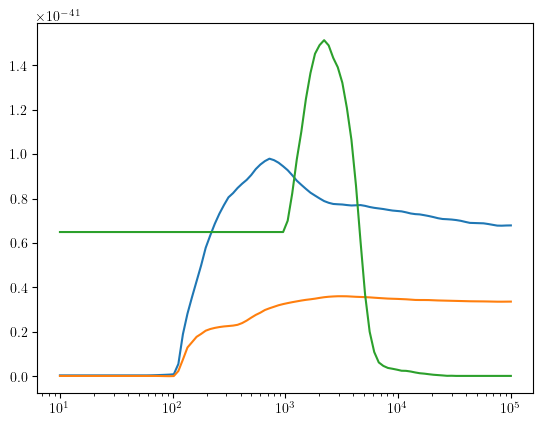

In [13]:
fine_energies = np.logspace(1, 5, 100)

plt.plot(fine_energies, numu_xs(fine_energies)/fine_energies, label="$\nu_\mu$")
plt.plot(fine_energies, numubar_xs(fine_energies)/fine_energies, label="$\bar{\nu}_\mu$")
plt.plot(fine_energies, numu_diff_flux(fine_energies)/1e60)
plt.xscale('log')
plt.show()


# check number of neutrino events per year

### old method

In [14]:
# Check total number of nu events per year
print("Number of numu = ", n_interactions_genie*np.sum(numu_events(numu_fhc_diff_flux[:,0])))
print("Number of nue = ", n_interactions_genie*np.sum(nue_events(nue_fhc_diff_flux[:,0])))
print("Number of nuebar = ", n_interactions_genie*np.sum(nuebar_events(nuebar_fhc_diff_flux[:,0])))
print("Number of numubar = ", n_interactions_genie*np.sum(numubar_events(numubar_fhc_diff_flux[:,0])))
print("Total number = ", n_interactions_genie*np.sum(numu_events(numu_fhc_diff_flux[:,0])) + n_interactions_genie*np.sum(nue_events(nue_fhc_diff_flux[:,0])) \
      + n_interactions_genie*np.sum(nuebar_events(nuebar_fhc_diff_flux[:,0])) + n_interactions_genie*np.sum(numubar_events(numubar_fhc_diff_flux[:,0])))


Number of numu =  11231999999.999994
Number of nue =  81900000.00000004
Number of nuebar =  11700000.0
Number of numubar =  327600000.0000002
Total number =  11653199999.999994


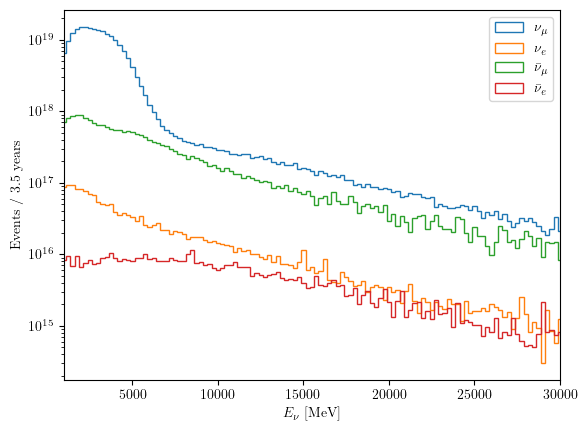

In [15]:
plt.hist(numu_fhc_diff_flux[:,0], weights=numu_fhc_diff_flux[:,1], bins=nu_e_bin_edges, label=r"$\nu_\mu$", histtype='step')
plt.hist(nue_fhc_diff_flux[:,0],  weights=nue_fhc_diff_flux[:,1], bins=nu_e_bin_edges,  label=r"$\nu_e$", histtype='step')
plt.hist(numubar_fhc_diff_flux[:,0],  weights=numubar_fhc_diff_flux[:,1], bins=nu_e_bin_edges,  label=r"$\bar{\nu}_\mu$", histtype='step')
plt.hist(nuebar_fhc_diff_flux[:,0],  weights=nuebar_fhc_diff_flux[:,1], bins=nu_e_bin_edges,  label=r"$\bar{\nu}_e$", histtype='step')
plt.yscale('log')
#plt.xscale('log')
plt.xlim((1000, 30e3))
plt.xlabel(r"$E_\nu$ [MeV]")
plt.ylabel(r"Events / 3.5 years")
plt.legend()
plt.show()

### 1gamma, 1e-, 1e+

In [16]:
# Import backgrounds
def get_1particle_array(datfile, flavor="numu", mass_energy=0.0):
    bkg = np.genfromtxt(datfile)
    bkg *= 1.0e3  # convert to MeV
    p0_em = bkg[:,0] + mass_energy
    p1_em = bkg[:,1]
    p2_em = bkg[:,2]
    p3_em = bkg[:,3]
    nu_energy = bkg[:,4]
    if flavor == "numu":
        weights = numu_events(nu_energy)
    elif flavor == "nue":
        weights = nue_events(nu_energy)
    elif flavor == "numubar":
        weights = numubar_events(nu_energy)
    elif flavor == "nuebar":
        weights = nuebar_events(nu_energy)
    return p0_em, p1_em, p2_em, p3_em, weights

def get_2particle_array(datfile, flavor="numu", mass_energy=0.0):
    bkg = np.genfromtxt(datfile)
    bkg *= 1.0e3  # convert to MeV
    p0_1 = bkg[:,0] + mass_energy
    p1_1 = bkg[:,1]
    p2_1 = bkg[:,2]
    p3_1 = bkg[:,3]
    p0_2 = bkg[:,4] + mass_energy
    p1_2 = bkg[:,5]
    p2_2 = bkg[:,6]
    p3_2 = bkg[:,7]
    nu_energy = bkg[:,8]
    if flavor == "numu":
        weights = numu_events(nu_energy)
    elif flavor == "nue":
        weights = nue_events(nu_energy)
    elif flavor == "numubar":
        weights = numubar_events(nu_energy)
    elif flavor == "nuebar":
        weights = nuebar_events(nu_energy)
    return p0_1, p1_1, p2_1, p3_1, p0_2, p1_2, p2_2, p3_2, weights

p0_g_nue, p1_g_nue, p2_g_nue, p3_g_nue, weights1_nue_g = get_1particle_array("data/1g0p/1gamma_nue_4vectors_DUNE_bkg.txt", flavor="nue")
p0_em_nue, p1_em_nue, p2_em_nue, p3_em_nue, weights1_nue_em = get_1particle_array("data/1g0p/1em_nue_4vectors_DUNE_bkg.txt", flavor="nue")
p0_ep_nue, p1_ep_nue, p2_ep_nue, p3_ep_nue, weights1_nue_ep = get_1particle_array("data/1g0p/1ep_nue_4vectors_DUNE_bkg.txt", flavor="nue")

p0_g_numu, p1_g_numu, p2_g_numu, p3_g_numu, weights1_numu_g = get_1particle_array("data/1g0p/1gamma_numu_4vectors_DUNE_bkg.txt", flavor="numu")
p0_em_numu, p1_em_numu, p2_em_nue, p3_em_numu, weights1_numu_em = get_1particle_array("data/1g0p/1em_numu_4vectors_DUNE_bkg.txt", flavor="numu")
p0_ep_numu, p1_ep_numu, p2_ep_numu, p3_ep_numu, weights1_numu_ep = get_1particle_array("data/1g0p/1ep_numu_4vectors_DUNE_bkg.txt", flavor="numu")

p0_g_nuebar, p1_g_nuebar, p2_g_nuebar, p3_g_nuebar, weights1_nuebar_g = get_1particle_array("data/1g0p/1gamma_nuebar_4vectors_DUNE_bkg.txt", flavor="nuebar")
p0_em_nuebar, p1_em_nuebar, p2_em_nuebar, p3_em_nuebar, weights1_nuebar_em = get_1particle_array("data/1g0p/1em_nuebar_4vectors_DUNE_bkg.txt", flavor="nuebar")
p0_ep_nuebar, p1_ep_nuebar, p2_ep_nuebar, p3_ep_nuebar, weights1_nuebar_ep = get_1particle_array("data/1g0p/1ep_nuebar_4vectors_DUNE_bkg.txt", flavor="nuebar")

p0_g_numubar, p1_g_numubar, p2_g_numubar, p3_g_numubar, weights1_numubar_g = get_1particle_array("data/1g0p/1gamma_numubar_4vectors_DUNE_bkg.txt", flavor="numubar")
p0_em_numubar, p1_em_numubar, p2_em_numubar, p3_em_numubar, weights1_numubar_em = get_1particle_array("data/1g0p/1em_numubar_4vectors_DUNE_bkg.txt", flavor="numubar")
p0_ep_numubar, p1_ep_numubar, p2_ep_numubar, p3_ep_numubar, weights1_numubar_ep = get_1particle_array("data/1g0p/1ep_numubar_4vectors_DUNE_bkg.txt", flavor="numubar")

In [17]:
print("1gamma, nu_e: ", np.sum(weights1_nue_g))
print("1ep, nu_e: ", E2GAMMA_MISID*np.sum(weights1_nue_ep))
print("1em, nu_e: ", E2GAMMA_MISID*np.sum(weights1_nue_em))

print("1gamma, nu_mu: ", np.sum(weights1_numu_g))
print("1ep, nu_mu: ", E2GAMMA_MISID*np.sum(weights1_numu_ep))
print("1em, nu_mu: ", E2GAMMA_MISID*np.sum(weights1_numu_em))

print("1gamma, nu_ebar: ", np.sum(weights1_nuebar_g))
print("1ep, nu_ebar: ", E2GAMMA_MISID*np.sum(weights1_nuebar_ep))
print("1em, nu_ebar: ", E2GAMMA_MISID*np.sum(weights1_nuebar_em))

print("1gamma, nu_mubar: ", np.sum(weights1_numubar_g))
print("1ep, nu_mubar: ", E2GAMMA_MISID*np.sum(weights1_numubar_ep))
print("1em, nu_mubar: ", E2GAMMA_MISID*np.sum(weights1_numubar_em))

1gamma, nu_e:  5567.800000000004
1ep, nu_e:  1159.9938000000006
1em, nu_e:  93612.27960000034
1gamma, nu_mu:  557443.1999999998
1ep, nu_mu:  110204.92799999996
1em, nu_mu:  110223.93599999994
1gamma, nu_ebar:  745.75
1ep, nu_ebar:  12582.764999999798
1em, nu_ebar:  151.5222
1gamma, nu_mubar:  18421.480000000014
1ep, nu_mubar:  3656.9736000000025
1em, nu_mubar:  3659.0400000000027


### 2 gamma counts

In [18]:

p0_2g_nue_1, p1_2g_nue_1, p2_2g_nue_1, p3_2g_nue_1, p0_2g_nue_2, p1_2g_nue_2, p2_2g_nue_2, p3_2g_nue_2, weights1_nue_2g = get_2particle_array("data/2gamma/2gamma_nue_4vectors_DUNE_bkg.txt", flavor="nue")
p0_2g_numu_1, p1_2g_numu_1, p2_2g_numu_1, p3_2g_numu_1, p0_2g_numu_2, p1_2g_numu_2, p2_2g_numu_2, p3_2g_numu_2, weights1_numu_2g = get_2particle_array("data/2gamma/2gamma_numu_4vectors_DUNE_bkg.txt", flavor="numu")
p0_2g_nuebar_1, p1_2g_nuebar_1, p2_2g_nuebar_1, p3_2g_nuebar_1, p0_2g_nuebar_2, p1_2g_nuebar_2, p2_2g_nuebar_2, p3_2g_nuebar_2, weights1_nuebar_2g = get_2particle_array("data/2gamma/2gamma_nuebar_4vectors_DUNE_bkg.txt", flavor="nuebar")
p0_2g_numubar_1, p1_2g_numubar_1, p2_2g_numubar_1, p3_2g_numubar_1, p0_2g_numubar_2, p1_2g_numubar_2, p2_2g_numubar_2, p3_2g_numubar_2, weights1_numubar_2g = get_2particle_array("data/2gamma/2gamma_numubar_4vectors_DUNE_bkg.txt", flavor="numubar")

print("2gamma, nu_mu: ", np.sum(weights1_numu_2g))
print("2gamma, nu_e: ", np.sum(weights1_nue_2g))
print("2gamma, nu_mubar: ", np.sum(weights1_numubar_2g))
print("2gamma, nu_ebar: ", np.sum(weights1_nuebar_2g))


2gamma, nu_mu:  154319.99999999997
2gamma, nu_e:  2059.120000000001
2gamma, nu_mubar:  9313.360000000004
2gamma, nu_ebar:  454.92


### 1gamma 1e- / 1e+

In [19]:

p0_1g1em_nue_1, p1_1g1em_nue_1, p2_1g1em_nue_1, p3_1g1em_nue_1, \
    p0_1g1em_nue_2, p1_1g1em_nue_2, p2_1g1em_nue_2, p3_1g1em_nue_2, weights1_nue_1g1em = get_2particle_array("data/1g1e0p/emgamma_nue_4vectors_DUNE_bkg.txt", flavor="nue")
p0_1g1em_numu_1, p1_1g1em_numu_1, p2_1g1em_numu_1, p3_1g1em_numu_1, \
    p0_1g1em_numu_2, p1_1g1em_numu_2, p2_1g1em_numu_2, p3_1g1em_numu_2, weights1_numu_1g1em = get_2particle_array("data/1g1e0p/emgamma_numu_4vectors_DUNE_bkg.txt", flavor="numu")
p0_1g1em_nuebar_1, p1_1g1em_nuebar_1, p2_1g1em_nuebar_1, p3_1g1em_nuebar_1, \
     p0_1g1em_nuebar_2, p1_1g1em_nuebar_2, p2_1g1em_nuebar_2, p3_1g1em_nuebar_2, weights1_nuebar_1g1em = get_2particle_array("data/1g1e0p/emgamma_nuebar_4vectors_DUNE_bkg.txt", flavor="nuebar")
p0_1g1em_numubar_1, p1_1g1em_numubar_1, p2_1g1em_numubar_1, p3_1g1em_numubar_1, \
     p0_1g1em_numubar_2, p1_1g1em_numubar_2, p2_1g1em_numubar_2, p3_1g1em_numubar_2, weights1_numubar_1g1em = get_2particle_array("data/1g1e0p/emgamma_numubar_4vectors_DUNE_bkg.txt", flavor="numubar")


p0_1g1ep_nue_1, p1_1g1ep_nue_1, p2_1g1ep_nue_1, p3_1g1ep_nue_1, \
     p0_1g1ep_nue_2, p1_1g1ep_nue_2, p2_1g1ep_nue_2, p3_1g1ep_nue_2, weights1_nue_1g1ep = get_2particle_array("data/1g1e0p/epgamma_nue_4vectors_DUNE_bkg.txt", flavor="nue")
p0_1g1ep_numu_1, p1_1g1ep_numu_1, p2_1g1ep_numu_1, p3_1g1ep_numu_1, \
     p0_1g1ep_numu_2, p1_1g1ep_numu_2, p2_1g1ep_numu_2, p3_1g1ep_numu_2, weights1_numu_1g1ep = get_2particle_array("data/1g1e0p/epgamma_numu_4vectors_DUNE_bkg.txt", flavor="numu")
p0_1g1ep_nuebar_1, p1_1g1ep_nuebar_1, p2_1g1ep_nuebar_1, p3_1g1ep_nuebar_1, \
     p0_1g1ep_nuebar_2, p1_1g1ep_nuebar_2, p2_1g1ep_nuebar_2, p3_1g1ep_nuebar_2, weights1_nuebar_1g1ep = get_2particle_array("data/1g1e0p/epgamma_nuebar_4vectors_DUNE_bkg.txt", flavor="nuebar")
p0_1g1ep_numubar_1, p1_1g1ep_numubar_1, p2_1g1ep_numubar_1, p3_1g1ep_numubar_1, \
     p0_1g1ep_numubar_2, p1_1g1ep_numubar_2, p2_1g1ep_numubar_2, p3_1g1ep_numubar_2, weights1_numubar_1g1ep = get_2particle_array("data/1g1e0p/epgamma_numubar_4vectors_DUNE_bkg.txt", flavor="numubar")



print("1g1em, nu_e: ", np.sum(weights1_nue_1g1em))
print("1g1em, nu_mu: ", np.sum(weights1_numu_1g1em))
print("1g1em, nu_ebar: ", np.sum(weights1_nuebar_1g1em))
print("1g1em, nu_mubar: ", np.sum(weights1_numubar_1g1em))

print("1g1ep, nu_e: ", np.sum(weights1_nue_1g1ep))
print("1g1ep, nu_mu: ", np.sum(weights1_numu_1g1ep))
print("1g1ep, nu_ebar: ", np.sum(weights1_nuebar_1g1ep))
print("1g1ep, nu_mubar: ", np.sum(weights1_numubar_1g1ep))

1g1em, nu_e:  39.2
1g1em, nu_mu:  1804.7999999999997
1g1em, nu_ebar:  6.12
1g1em, nu_mubar:  120.40000000000006
1g1ep, nu_e:  2431.3100000000013
1g1ep, nu_mu:  298339.19999999995
1g1ep, nu_ebar:  374.92
1g1ep, nu_mubar:  9153.760000000006


### e+e-

In [20]:

p0_epem_nue_1, p1_epem_nue_1, p2_epem_nue_1, p3_epem_nue_1, \
    p0_epem_nue_2, p1_epem_nue_2, p2_epem_nue_2, p3_epem_nue_2, weights1_nue_epem = get_2particle_array("data/1em1ep/epem_nue_4vectors_DUNE_bkg.txt", flavor="nue")
p0_epem_numu_1, p1_epem_numu_1, p2_epem_numu_1, p3_epem_numu_1, \
    p0_epem_numu_2, p1_epem_numu_2, p2_epem_numu_2, p3_epem_numu_2, weights1_numu_epem = get_2particle_array("data/1em1ep/epem_numu_4vectors_DUNE_bkg.txt", flavor="numu")
p0_epem_nuebar_1, p1_epem_nuebar_1, p2_epem_nuebar_1, p3_epem_nuebar_1, \
     p0_epem_nuebar_2, p1_epem_nuebar_2, p2_epem_nuebar_2, p3_epem_nuebar_2, weights1_nuebar_epem = get_2particle_array("data/1em1ep/epem_nuebar_4vectors_DUNE_bkg.txt", flavor="nuebar")
p0_epem_numubar_1, p1_epem_numubar_1, p2_epem_numubar_1, p3_epem_numubar_1, \
     p0_epem_numubar_2, p1_epem_numubar_2, p2_epem_numubar_2, p3_epem_numubar_2, weights1_numubar_epem = get_2particle_array("data/1em1ep/epem_numubar_4vectors_DUNE_bkg.txt", flavor="numubar")



print("epem, nu_e: ", np.sum(weights1_nue_epem))
print("epem, nu_mu: ", np.sum(weights1_numu_epem))
print("epem, nu_ebar: ", np.sum(weights1_nuebar_epem))
print("epem, nu_mubar: ", np.sum(weights1_numubar_epem))

epem, nu_e:  1637.1600000000008
epem, nu_mu:  612239.9999999998
epem, nu_ebar:  257.02
epem, nu_mubar:  20316.520000000015


# Plots: 2 gamma

In [21]:
digamma_nue_sep_angle = arccos((p1_2g_nue_1*p1_2g_nue_2 + p2_2g_nue_1*p2_2g_nue_2 + p3_2g_nue_1*p3_2g_nue_2)/(sqrt(p1_2g_nue_1**2 + p2_2g_nue_1**2 + p3_2g_nue_1**2)*sqrt(p1_2g_nue_2**2 + p2_2g_nue_2**2 + p3_2g_nue_2**2)))
digamma_numu_sep_angle = arccos((p1_2g_numu_1*p1_2g_numu_2 + p2_2g_numu_1*p2_2g_numu_2 + p3_2g_numu_1*p3_2g_numu_2)/(sqrt(p1_2g_numu_1**2 + p2_2g_numu_1**2 + p3_2g_numu_1**2)*sqrt(p1_2g_numu_2**2 + p2_2g_numu_2**2 + p3_2g_numu_2**2)))
digamma_nuebar_sep_angle = arccos((p1_2g_nuebar_1*p1_2g_nuebar_2 + p2_2g_nuebar_1*p2_2g_nuebar_2 + p3_2g_nuebar_1*p3_2g_nuebar_2)/(sqrt(p1_2g_nuebar_1**2 + p2_2g_nuebar_1**2 + p3_2g_nuebar_1**2)*sqrt(p1_2g_nuebar_2**2 + p2_2g_nuebar_2**2 + p3_2g_nuebar_2**2)))
digamma_numubar_sep_angle = arccos((p1_2g_numubar_1*p1_2g_numubar_2 + p2_2g_numubar_1*p2_2g_numubar_2 + p3_2g_numubar_1*p3_2g_numubar_2)/(sqrt(p1_2g_numubar_1**2 + p2_2g_numubar_1**2 + p3_2g_numubar_1**2)*sqrt(p1_2g_numubar_2**2 + p2_2g_numubar_2**2 + p3_2g_numubar_2**2)))

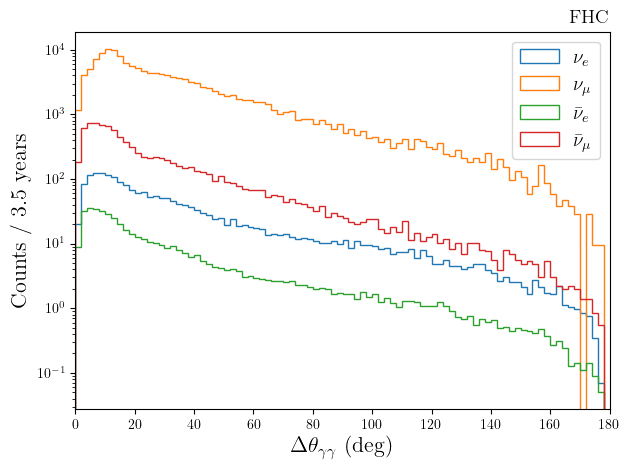

In [22]:
sep_angle_bins = np.arange(0.0, 180.0, 2)
rad2deg = 180.0/np.pi

plt.hist(rad2deg*digamma_nue_sep_angle, weights=weights1_nue_2g, bins=sep_angle_bins, histtype='step', label=r"$\nu_e$")
plt.hist(rad2deg*digamma_numu_sep_angle, weights=weights1_numu_2g, bins=sep_angle_bins, histtype='step', label=r"$\nu_\mu$")
plt.hist(rad2deg*digamma_nuebar_sep_angle, weights=weights1_nuebar_2g, bins=sep_angle_bins, histtype='step', label=r"$\bar{\nu}_e$")
plt.hist(rad2deg*digamma_numubar_sep_angle, weights=weights1_numubar_2g, bins=sep_angle_bins, histtype='step', label=r"$\bar{\nu}_\mu$")
plt.xlim((0.0,180.0))
plt.ylabel(r"Counts / 3.5 years", fontsize=16)
plt.xlabel(r"$\Delta\theta_{\gamma\gamma}$ (deg)", fontsize=16)
plt.title('FHC', loc="right", fontsize=14)
plt.yscale('log')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

[3.00000000e+01 4.20637385e+01 5.89786033e+01 8.26953516e+01
 1.15949188e+02 1.62575211e+02 2.27950706e+02 3.19615296e+02
 4.48140475e+02 6.28348792e+02 8.81023309e+02 1.23530447e+03
 1.73205081e+03 2.42855108e+03 3.40513125e+03 4.77441835e+03
 6.69432950e+03 9.38628419e+03 1.31607401e+04 1.84529977e+04
 2.58734024e+04 3.62777344e+04 5.08659045e+04 7.13203368e+04
 1.00000000e+05]


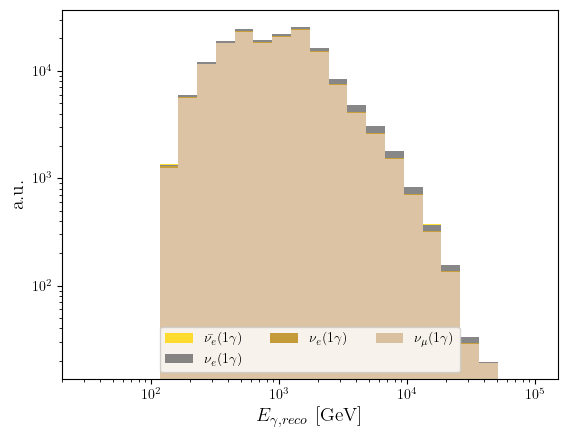

In [23]:
bkg_2g_ebins = np.logspace(np.log10(30.0), np.log10(100.0e3), 25)
print(bkg_2g_ebins)
plt.hist([(p0_2g_numu_1+p0_2g_numu_2), (p0_2g_nue_1+p0_2g_nue_2), (p0_2g_numubar_1+p0_2g_numubar_2), (p0_2g_nuebar_1+p0_2g_nuebar_2)],
         weights=[weights1_numu_2g, weights1_nue_2g, weights1_numubar_2g, weights1_nuebar_2g],
         label=[r"$\nu_\mu(1\gamma)$", r"$\nu_e(1\gamma)$", r"$\nu_e(1\gamma)$", r"$\bar{\nu_e}(1\gamma)$"],
         color=['tan', 'darkgoldenrod', 'dimgray', 'gold'],
         stacked=True, bins=bkg_2g_ebins, histtype='stepfilled', alpha=0.8)
#plt.xlim((0.0, 20.0))
plt.yscale('log')
plt.xscale('log')
plt.ylabel("a.u.", fontsize=14)
plt.xlabel(r"$E_{\gamma,{reco}}$ [GeV]", fontsize=14)
plt.legend(ncol=3)
plt.show()

# 1 gamma

### Energy distributions

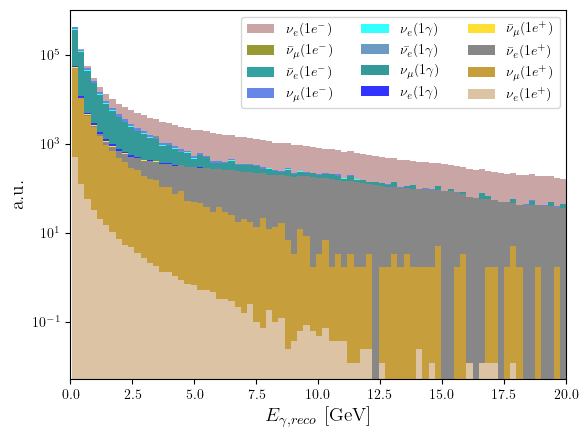

In [24]:
bkg_gev_bin_edges = np.linspace(0.05, 20.0, 80)

plt.hist([1e-3*p0_ep_nue, 1e-3*p0_ep_numu, 1e-3*p0_ep_nuebar, 1e-3*p0_ep_numubar, 1e-3*p0_g_nue, 1e-3*p0_g_numu, 1e-3*p0_g_nuebar,
          1e-3*p0_g_numubar, 1e-3*p0_em_numu, 1e-3*p0_em_nuebar, 1e-3*p0_em_numubar, 1e-3*p0_em_nue,],
         weights=[E2GAMMA_MISID*weights1_nue_ep, E2GAMMA_MISID*weights1_numu_ep, E2GAMMA_MISID*weights1_nuebar_ep,
                  E2GAMMA_MISID*weights1_numubar_ep, weights1_nue_g, weights1_numu_g, weights1_nuebar_g, weights1_numubar_g,
                  E2GAMMA_MISID*weights1_numu_em, E2GAMMA_MISID*weights1_nuebar_em, E2GAMMA_MISID*weights1_numubar_em,
                  E2GAMMA_MISID*weights1_nue_em],
         label=[r"$\nu_e(1e^+)$", r"$\nu_\mu(1e^+)$", r"$\bar{\nu}_e(1e^+)$", r"$\bar{\nu}_\mu(1e^+)$", 
                r"$\nu_e(1\gamma)$", r"$\nu_\mu(1\gamma)$", r"$\bar{\nu_e}(1\gamma)$", r"$\nu_e(1\gamma)$", r"$\nu_\mu(1e^-)$", r"$\bar{\nu}_e (1e^-)$",
                r"$\bar{\nu}_\mu(1e^-)$", r"$\nu_e(1e^-)$"],
         color=['tan', 'darkgoldenrod', 'dimgray', 'gold', 'b', 'teal', 'steelblue', 'cyan', 'royalblue', 'darkcyan', 'olive', 'rosybrown'],
         stacked=True, bins=bkg_gev_bin_edges, histtype='stepfilled', alpha=0.8)
plt.xlim((0.0, 20.0))
plt.yscale('log')
plt.ylabel("a.u.", fontsize=14)
plt.xlabel(r"$E_{\gamma,{reco}}$ [GeV]", fontsize=14)
plt.legend(ncol=3)
plt.show()

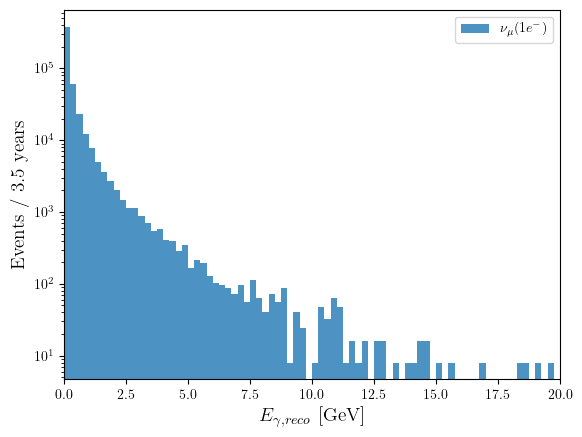

In [25]:
bkg_bin_edges_250 = np.arange(0.0, 30.250, 0.250)

hist2 = np.histogram(1e-3*p0_em_numu, weights=weights1_numu_em, bins=bkg_bin_edges_250)

plt.hist(1e-3*p0_em_numu,
         weights=(8e7/1e7) * np.ones_like(p0_em_numu),
         label=[r"$\nu_\mu(1e^-)$"],
         stacked=False, bins=bkg_bin_edges_250, histtype='stepfilled', alpha=0.8)
plt.xlim((0.0, 20.0))
plt.yscale('log')
plt.ylabel("Events / 3.5 years", fontsize=14)
plt.xlabel(r"$E_{\gamma,{reco}}$ [GeV]", fontsize=14)
plt.legend(ncol=3)
plt.show()

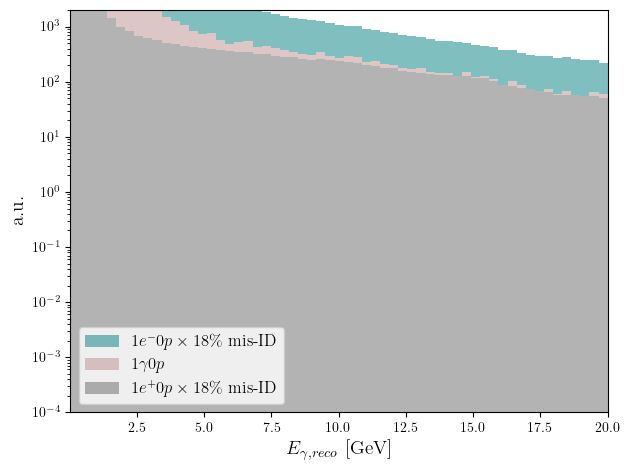

In [26]:
bkg_energy_bins = np.linspace(30.0e-3, 20, 60)  # GeV

p0_ep_allfl = np.append(p0_ep_nuebar, np.append(p0_ep_numubar, np.append(p0_ep_nue, p0_ep_numu)))
p0_em_allfl = np.append(p0_em_nuebar, np.append(p0_em_numubar, np.append(p0_em_nue, p0_em_numu)))
p0_g_allfl = np.append(p0_g_nuebar, np.append(p0_g_numubar, np.append(p0_g_nue, p0_g_numu)))

wgt_ep_allfl = np.append(weights1_nuebar_ep, np.append(weights1_numubar_ep, np.append(weights1_nue_ep, weights1_numu_ep)))
wgt_em_allfl = np.append(weights1_nuebar_em, np.append(weights1_numubar_em, np.append(weights1_nue_em, weights1_numu_em)))
wgt_g_allfl = np.append(weights1_nuebar_g, np.append(weights1_numubar_g, np.append(weights1_nue_g, weights1_numu_g)))


# Total energy
plt.hist([1e-3*p0_ep_allfl, 1e-3*p0_g_allfl, 1e-3*p0_em_allfl], weights=[E2GAMMA_MISID*wgt_ep_allfl, wgt_g_allfl, E2GAMMA_MISID*wgt_em_allfl],
         bins=bkg_energy_bins, label=[r"$1e^+ 0p \times 18$\% mis-ID", r"$1\gamma 0p$", r"$1e^- 0p \times 18$\% mis-ID"],
         stacked=True, histtype='stepfilled', color=['dimgray', 'rosybrown', 'teal'], alpha=0.5)
#plt.hist(1e-3*etotal_1MeV, weights=wgts_1MeV, bins=bkg_energy_bins,
#            label="Collinear ALP Decays ($m_a = 1$ MeV)", color='b', histtype='step')
#plt.hist(1e-3*etotal_10MeV, weights=wgts_10MeV, bins=bkg_energy_bins,
#            label="Collinear ALP Decays ($m_a = 10$ MeV)", color='r', histtype='step')
#plt.hist(1e-3*etotal_100MeV, weights=wgts_100MeV, bins=bkg_energy_bins,
#            label="Collinear ALP Decays ($m_a = 100$ MeV)", color='forestgreen', histtype='step')
plt.ylabel(r"a.u.", fontsize=14)
plt.xlabel(r"$E_{\gamma,{reco}}$ [GeV]", fontsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
#plt.title("FHC", loc="right")
plt.xlim((bkg_energy_bins[0], bkg_energy_bins[-1]))
plt.ylim((1e-4,2e3))
plt.tight_layout()
plt.show()
plt.close()